### Implementation of NMF Algorithms on ORL and Cropped YaleB image database

##### Function to Load Data

In [118]:
import os
import numpy as np
from PIL import Image
from IPython.display import Markdown, display
import random

from IPython.display import Markdown, display

def load_data(root='/data/CroppedYaleB', reduce=3):
    
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue   
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

           

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [121]:
#Function to generate gaussian noise
def GenerateGaussianNoise(image, mean=0.0, sigma=20):
    ''' 
    calculated the non-negative matrix factorization objective
    
    Usage:
        W, H = update(V, W, H)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    Returns:
        F: a scalar objective
    ''' 
    #print('\n==> Add Gaussian Noise ...')
    row,col = image.shape
    noise = np.random.normal(mean,sigma,(row,col))
    noise = noise.reshape(row,col)
    return noise

In [61]:
#function to generate salt & pepper noise
def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

##### Loading ORL Dataset and Showing Corrupted Image with Random Noise

==> Load ORL dataset ...
V1_hat.shape=(1110, 400), Y1_hat.shape=(400,)


/Users/sriramswa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


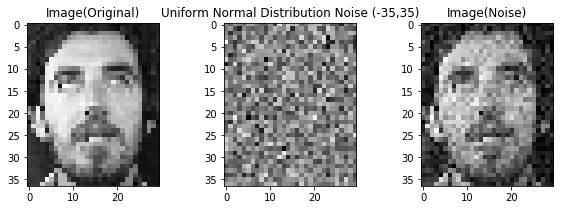

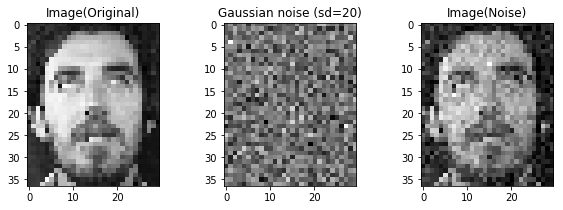

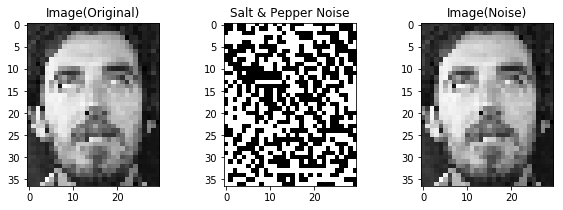

In [122]:
# Load dataset.
print('==> Load ORL dataset ...')
V1_hat, Y1_hat = load_data('/data/ORL', reduce=3)
print('V1_hat.shape={}, Y1_hat.shape={}'.format(V1_hat.shape, Y1_hat.shape))

# Add Noise.

#uniform distribution noise
V1_noise = np.random.uniform(-35,35,V1_hat.shape)
#gaussian noise
V_noise2=GenerateGaussianNoise(V1_hat, mean=0.0, sigma=20)
#salt & pepper noise
V_noise3=sp_noise(V_hat, prob = 0.5)

#Adding the three noises to the original image
V1 = V1_hat + V_noise1
V2 = V1_hat + V_noise2
V3 = V1_hat + V_noise3
for i in range(V1.shape[0]):
    for j in range(V1.shape[1]):
        V1[i,j]=round(max(min((V1_hat[i,j] + V_noise1[i,j]),255),0))
        V2[i,j]=round(max(min((V1_hat[i,j] + V_noise2[i,j]),255),0))
        V3[i,j]=round(max(min((V1_hat[i,j] + V_noise3[i,j]),255),0))

#V1= round(max(min((V_hat[i] + V_noise1),255),0))

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 25 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V1_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Uniform Normal Distribution Noise (-35,35)')
plt.subplot(133)
plt.imshow(V1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

img_size = [i//3 for i in (92, 112)] # ORL
ind = 25 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V1_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Gaussian noise (sd=20)')
plt.subplot(133)
plt.imshow(V2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

img_size = [i//3 for i in (92, 112)] # ORL
ind = 25 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V1_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise3[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Salt & Pepper Noise')
plt.subplot(133)
plt.imshow(V3[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

plt.show()

##### Implementation of NMF and Multiplicative Update functions using L2-Norm and KL-Divergence

In [127]:
#NMF Algorithm

import numpy as np

def l2_objective(V, W, H):
    ''' calculated the non-negative matrix factorization objective
        
    Usage:
        W, H = update(V, W, H)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    Returns:
        F: a scalar objective-cost
    '''    
    
    
    
    WH = np.dot(W, H)
    V_new=V-WH
    
    F= np.linalg.norm(V_new, 2)
    return F

def KL_objective(V, W, H):
    ''' calculated the non-negative matrix factorization objective
        
    Usage:
        W, H = update(V, W, H)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    Returns:
        F: a scalar objective-cost
    '''    
    
    
    d, n = V.shape
    WH = np.dot(W, H)
    V_new=V-WH
    #normalized KL divergence nmf
    F = (V * np.log(WH) - WH).sum() / (d * n)
    
    return F


def updateW(V, W, H):
    ''' performs the multiplicative non-negative matrix factorization updates for W
        
    Usage:
        W, H = update(V, W, H)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    Returns:
        W: (d x k)-array of updated non-negative basis images (components)
    '''
    
    WH = np.dot(W, H)
    W_new = W * np.dot(V / WH, H.T)
    W_new = W_new / np.sum(W_new, axis=0, keepdims=True)    
    return W_new

def updateH(V, W, H):
    ''' performs the multiplicative non-negative matrix factorization updates
        
    Usage:
        W, H = update(V, W, H)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    Returns:
        H: (k x n)-array of updated weights, one column for each of the n observations
    '''
    
    WH = np.dot(W, H)
    H_new = H * np.dot((V / WH).T, W).T
    return H_new


def l2_nmf(V, k, threshold=1e-5, maxiter=500):
    ''' decomposes V into r components by non-negative matrix factorization
        
    Usage:
        W, H = nmf(X, r)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        k: number of components to extract
        threshold: relative error threshold of the iteration
        maxiter: maximum number of iterations
    Returns:
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    '''
    
    
    W_svd,S,H_svd = np.linalg.svd(V, full_matrices=False)
    #print('W.shape = {}, H.shape = {}'.format(W_svd.shape, H_svd.shape))

    d, n = V.shape
    random.seed(1)#setting seed for initialization purpose
    W = np.random.rand(d, k)
    H = np.random.rand(k, n)
    F = l2_objective(V, W, H)
    cost=F
    it_no = 0
    converged = False

    while (not converged) and it_no <= maxiter:
        W_new = updateW(V, W, H)
        H_new = updateH(V, W_new, H)    
        F_new = l2_objective(V, W_new, H_new)
        cost=np.append(cost,F_new)
        converged = np.abs(F_new - F) <= threshold 
        W, H = W_new, H_new
        it_no = it_no + 1
    
    return W, H,cost

def KL_nmf(V, k, threshold=1e-5, maxiter=500):
    ''' decomposes V into r components by non-negative matrix factorization
        
    Usage:
        W, H = nmf(V, r)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        k: number of components to extract
        threshold: relative error threshold of the iteration
        maxiter: maximum number of iterations
    Returns:
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    '''
    
    d, n = V.shape
    random.seed(1)#setting seed for initialization purpose
    W = np.random.rand(d, k)
    H = np.random.rand(k, n)
    F = KL_objective(V, W, H)
    cost=F
    it_no = 0
    converged = False

    while (not converged) and it_no <= maxiter:
        W_new = updateW(V, W, H)
        H_new = updateH(V, W_new, H)    
        F_new = KL_objective(V, W_new, H_new)
        cost=np.append(cost,F_new)
        converged = np.abs(F_new - F) <= threshold 
        W, H = W_new, H_new
        it_no = it_no + 1
    
    return W, H,cost

In [128]:
def RRE(Vh,W,H):
    ''' 
    calculated the non-negative matrix factorization objective
        
    Usage:
        W, H = update(V, W, H)
    Parameters:
        V: a (d x n)-array containing n observations in the columns
        W: (d x k)-array of non-negative basis images (components)
        H: (k x n)-array of weights, one column for each of the n observations
    Returns:
        F: a scalar objective
    ''' 
    # Evaluate relative reconstruction errors.
    print('\n==> Evaluate RRE ...')
    RRE = np.linalg.norm(Vh - W.dot(H)) / np.linalg.norm(Vh)
    return RRE

#### Analysis of NMF Algorithms Using Corrupted ORL Dataset

##### Use L2-Norm NMF on the images- V1, V2 and V3 that were corrupted with Uniform Distribution, Gaussian and Salt & Pepper Noise

In [133]:

k1=2;k2=15;k3=40
#setting k=2
W1_L2_k1,H1_L2_k1,cost1_L2_k1=l2_nmf(V1,k1)
W2_L2_k1,H2_L2_k1,cost2_L2_k1=l2_nmf(V2,k1)
W3_L2_k1,H3_L2_k1,cost3_L2_k1=l2_nmf(V3,k1)

#setting k=15
W1_L2_k2,H1_L2_k2,cost1_L2_k2=l2_nmf(V1,k2)
W2_L2_k2,H2_L2_k2,cost2_L2_k2=l2_nmf(V2,k2)
W3_L2_k2,H3_L2_k2,cost3_L2_k2=l2_nmf(V3,k2)
#setting k=40
W1_L2_k3,H1_L2_k3,cost1_L2_k3=l2_nmf(V1,k3)
W2_L2_k3,H2_L2_k3,cost2_L2_k3=l2_nmf(V2,k3)
W3_L2_k3,H3_L2_k3,cost3_L2_k3=l2_nmf(V3,k3)


In [134]:
#Using KL Divergence NMF

k1=2;k2=15;k3=40
#setting k=2
W1_KL_k1,H1_KL_k1,cost1_KL_k1=l2_nmf(V1,k1)
W2_KL_k1,H2_KL_k1,cost2_KL_k1=l2_nmf(V2,k1)
W3_KL_k1,H3_KL_k1,cost3_KL_k1=l2_nmf(V3,k1)

#setting k=15
W1_KL_k2,H1_KL_k2,cost1_KL_k2=l2_nmf(V1,k2)
W2_KL_k2,H2_KL_k2,cost2_KL_k2=l2_nmf(V2,k2)
W3_KL_k2,H3_KL_k2,cost3_KL_k2=l2_nmf(V3,k2)
#setting k=40
W1_KL_k3,H1_KL_k3,cost1_KL_k3=l2_nmf(V1,k3)
W2_KL_k3,H2_KL_k3,cost2_KL_k3=l2_nmf(V2,k3)
W3_KL_k3,H3_KL_k3,cost3_KL_k3=l2_nmf(V3,k3)

##### Plotting Loss Function for the reconstructed images against iteration

			NMF algorithm on Uniform Distribution (-35,35) noise ORL image database with k=2


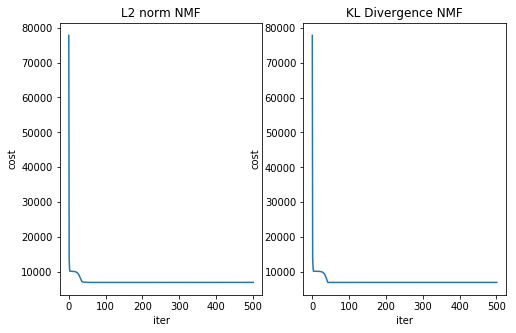

			NMF algorithm on Uniform Distribution (-35,35) noise ORL image database with k=15


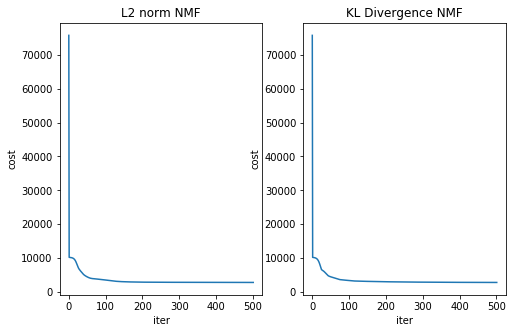

			NMF algorithm on Uniform Distribution (-35,35) noise ORL image database with k=40


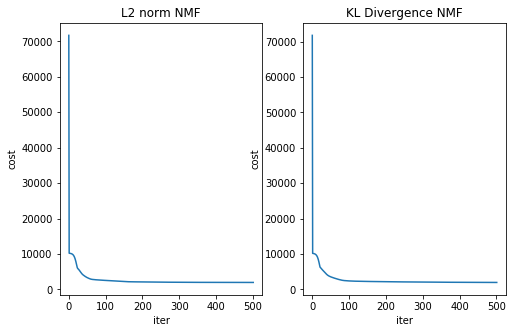

			NMF algorithm on Gaussian noise ORL image database with k=2


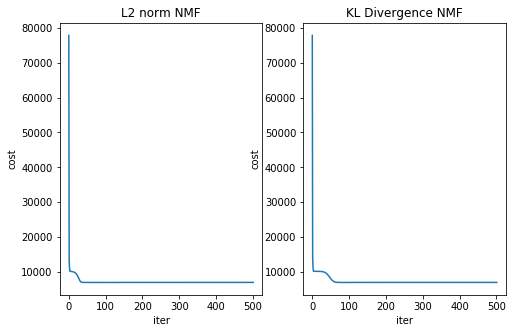

			NMF algorithm on Gaussian noise ORL image database with k=15


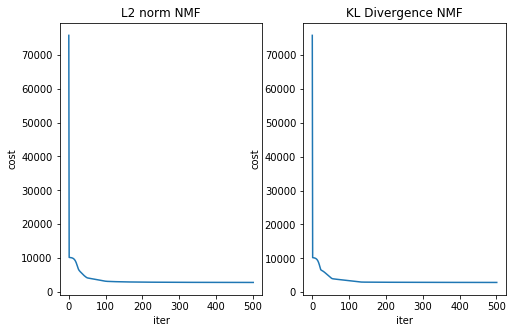

			NMF algorithm on Gaussian noise ORL image database with k=40


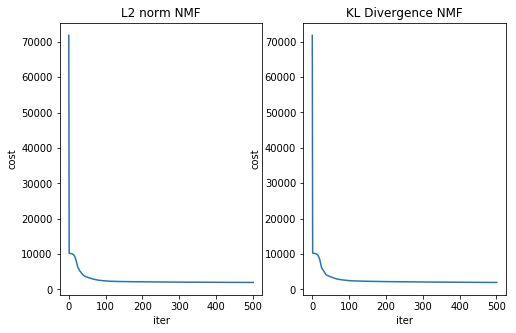

			NMF algorithm on Salt & Pepper noise ORL image database with k=2


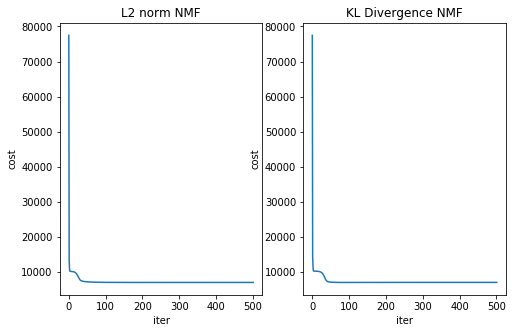

			NMF algorithm on Salt & Pepper noise ORL image database with k=15


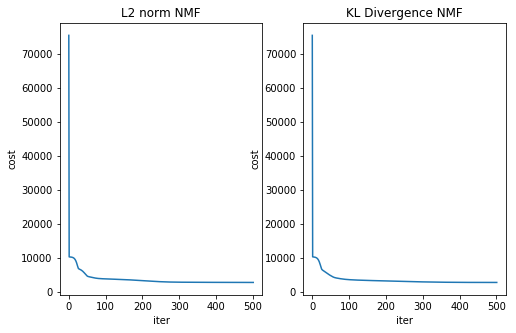

			NMF algorithm on Salt & Pepper noise ORL image database with k=40


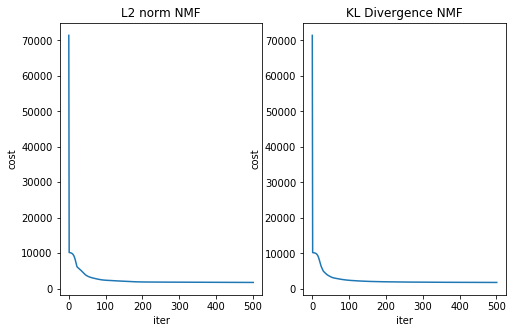

In [143]:
plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Uniform Distribution (-35,35) noise ORL image database with k=2''\x1b[0m')
plt.subplot(121)
plt.plot(cost1_L2_k1)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost1_KL_k1)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Uniform Distribution (-35,35) noise ORL image database with k=15''\x1b[0m')
plt.subplot(121)
plt.plot(cost1_L2_k2)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost1_KL_k2)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Uniform Distribution (-35,35) noise ORL image database with k=40''\x1b[0m')
plt.subplot(121)
plt.plot(cost1_L2_k3)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost1_KL_k3)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Gaussian noise ORL image database with k=2''\x1b[0m')
plt.subplot(121)
plt.plot(cost2_L2_k1)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost2_KL_k1)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Gaussian noise ORL image database with k=15''\x1b[0m')
plt.subplot(121)
plt.plot(cost2_L2_k2)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost2_KL_k2)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Gaussian noise ORL image database with k=40''\x1b[0m')
plt.subplot(121)
plt.plot(cost2_L2_k3)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost2_KL_k3)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Salt & Pepper noise ORL image database with k=2''\x1b[0m')
plt.subplot(121)
plt.plot(cost3_L2_k1)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost3_KL_k1)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Salt & Pepper noise ORL image database with k=15''\x1b[0m')
plt.subplot(121)
plt.plot(cost3_L2_k2)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost3_KL_k2)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Salt & Pepper noise ORL image database with k=40''\x1b[0m')
plt.subplot(121)
plt.plot(cost3_L2_k3)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost3_KL_k3)
plt.show()


##### Relative Reconstruction Errors (RRE)

In [145]:
RRE_ORL_L2_V1_k1=RRE(V1,W1_L2_k1,H1_L2_k1)
print("Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with L2-Norm NMF, K=2 =",round(RRE_ORL_L2_V1_k1,2))

RRE_ORL_L2_V1_k2=RRE(V1,W1_L2_k2,H1_L2_k2)
print("Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with L2-Norm NMF, K=15 =",round(RRE_ORL_L2_V1_k2,2))


RRE_ORL_L2_V1_k3=RRE(V1,W1_L2_k3,H1_L2_k3)
print("Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with L2-Norm NMF, K=40 =",round(RRE_ORL_L2_V1_k3,2))


RRE_ORL_L2_V2_k1=RRE(V2,W2_L2_k1,H2_L2_k1)
print("Relative Reconstruction Error for ORL noisy(gaussian) image data set with L2-Norm NMF, K=2 =",round(RRE_ORL_L2_V2_k1,2))

RRE_ORL_L2_V2_k2=RRE(V2,W2_L2_k2,H2_L2_k2)
print("Relative Reconstruction Error for ORL noisy(gaussian) image data set with L2-Norm NMF, K=15 =",round(RRE_ORL_L2_V2_k1,2))


RRE_ORL_L2_V2_k3=RRE(V2,W2_L2_k3,H2_L2_k3)
print("Relative Reconstruction Error for ORL noisy(gaussian) image data set with L2-Norm NMF, K=40 =",round(RRE_ORL_L2_V2_k1,2))


RRE_ORL_L2_V3_k1=RRE(V2,W3_L2_k1,H3_L2_k1)
print("Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with L2-Norm NMF, K=2 =",round(RRE_ORL_L2_V3_k1,2))

RRE_ORL_L2_V3_k2=RRE(V2,W3_L2_k2,H3_L2_k2)
print("Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with L2-Norm NMF, K=15 =",round(RRE_ORL_L2_V3_k1,2))


RRE_ORL_L2_V3_k3=RRE(V2,W3_L2_k3,H3_L2_k3)
print("Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with L2-Norm NMF, K=40 =",round(RRE_ORL_L2_V3_k1,2))

print("*********************************************************")

RRE_ORL_KL_V1_k1=RRE(V1,W1_KL_k1,H1_KL_k1)
print("Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with KL NMF, K=2 =",round(RRE_ORL_KL_V1_k1,2))

RRE_ORL_KL_V1_k2=RRE(V1,W1_KL_k2,H1_KL_k2)
print("Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with KL NMF, K=15 =",round(RRE_ORL_KL_V1_k2,2))


RRE_ORL_KL_V1_k3=RRE(V1,W1_KL_k3,H1_KL_k3)
print("Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with KL NMF, K=40 =",round(RRE_ORL_KL_V1_k3,2))


RRE_ORL_KL_V2_k1=RRE(V2,W2_KL_k1,H2_KL_k1)
print("Relative Reconstruction Error for ORL noisy(gaussian) image data set with KL NMF, K=2 =",round(RRE_ORL_KL_V2_k1,2))

RRE_ORL_KL_V2_k2=RRE(V2,W2_KL_k2,H2_KL_k2)
print("Relative Reconstruction Error for ORL noisy(gaussian) image data set with KLm NMF, K=15 =",round(RRE_ORL_KL_V2_k1,2))


RRE_ORL_KL_V2_k3=RRE(V2,W2_KL_k3,H2_KL_k3)
print("Relative Reconstruction Error for ORL noisy(gaussian) image data set with KL NMF, K=40 =",round(RRE_ORL_KL_V2_k1,2))


RRE_ORL_KL_V3_k1=RRE(V2,W3_KL_k1,H3_KL_k1)
print("Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with KL NMF, K=2 =",round(RRE_ORL_KL_V3_k1,2))

RRE_ORL_KL_V3_k2=RRE(V2,W3_KL_k2,H3_KL_k2)
print("Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with KL NMF, K=15 =",round(RRE_ORL_KL_V3_k1,2))


RRE_ORL_KL_V3_k3=RRE(V2,W3_KL_k3,H3_KL_k3)
print("Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with KL NMF, K=40 =",round(RRE_ORL_KL_V3_k1,2))






==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with L2-Norm NMF, K=2 = 0.31

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with L2-Norm NMF, K=15 = 0.25

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(uniform distribution) image data set with L2-Norm NMF, K=40 = 0.22

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(gaussian) image data set with L2-Norm NMF, K=2 = 0.31

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(gaussian) image data set with L2-Norm NMF, K=15 = 0.31

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(gaussian) image data set with L2-Norm NMF, K=40 = 0.31

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with L2-Norm NMF, K=2 = 0.31

==> Evaluate RRE ...
Relative Reconstruction Error for ORL noisy(Salt & pepper) image data set with L2-Norm NMF, K

##### Loading Cropped YaleB Dataset and Showing Corrupted Image with Random Noise

In [152]:
# Load dataset.
print('==> Load CroppedYaleB ...')
V2_hat, Y2_hat = load_data('/data/CroppedYaleB', reduce=3)
print('V2_hat.shape={}, Y2_hat.shape={}'.format(V2_hat.shape,Y2_hat.shape))

# Add Noise.
#uniform distribution noise
V_noise1 = np.random.uniform(-35,35,V2_hat.shape)
#gaussian noise
V_noise2=GenerateGaussianNoise(V2_hat, mean=0.0, sigma=20)
#salt & pepper noise
V_noise3=sp_noise(V2_hat, prob = 0.5)

#Adding the three noises to the original image
V11 = V2_hat + V_noise1
V22 = V2_hat + V_noise2
V33 = V2_hat + V_noise3
for i in range(V11.shape[0]):
    for j in range(V11.shape[1]):
        V11[i,j]=round(max(min((V2_hat[i,j] + V_noise1[i,j]),255),0))
        V22[i,j]=round(max(min((V2_hat[i,j] + V_noise2[i,j]),255),0))
        V33[i,j]=round(max(min((V2_hat[i,j] + V_noise3[i,j]),255),0))

#V1= round(max(min((V_hat[i] + V_noise1),255),0))





==> Load CroppedYaleB ...
V2_hat.shape=(3584, 2414), Y2_hat.shape=(2414,)


/Users/sriramswa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars


KeyboardInterrupt: 

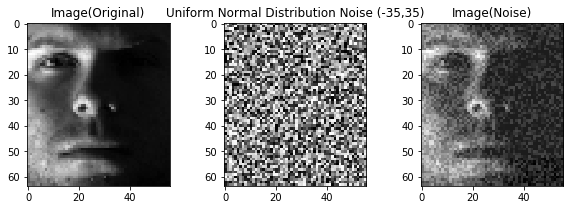

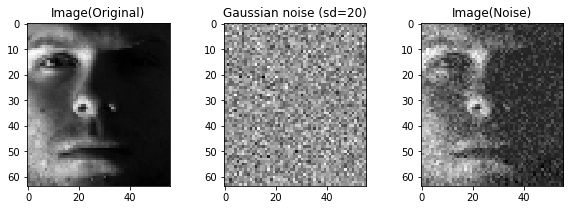

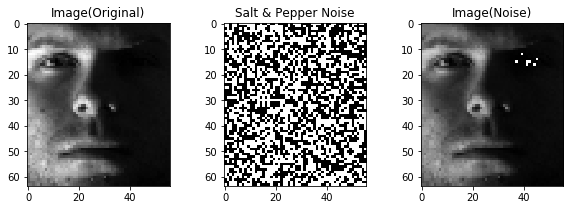

In [153]:
# Plot result.
import matplotlib.pyplot as plt
img_size = [i for i in (56, 64)] # YaleB
ind = 25 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V2_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Uniform Normal Distribution Noise (-35,35)')
plt.subplot(133)
plt.imshow(V11[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

#img_size = [i for i in (56,64)] #YaleB
ind = 25 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V2_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Gaussian noise (sd=20)')
plt.subplot(133)
plt.imshow(V22[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

#img_size = [i for i in (56,64)] # YaleB
ind = 25 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V2_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise3[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Salt & Pepper Noise')
plt.subplot(133)
plt.imshow(V33[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

plt.show()

##### Analysis of NMF Algorithms on Noisy Cropped YaleB Image Database


##### Use KL NMF on the images- V1, V2 and V3 that were corrupted with Uniform Distribution, Gaussian and Salt & Pepper Noise

In [154]:
k1=2;k2=15;k3=38
#setting k=2
W11_L2_k1,H11_L2_k1,cost11_L2_k1=l2_nmf(V11,k1)
W22_L2_k1,H22_L2_k1,cost22_L2_k1=l2_nmf(V22,k1)
W33_L2_k1,H33_L2_k1,cost33_L2_k1=l2_nmf(V33,k1)

#setting k=15
W11_L2_k2,H11_L2_k2,cost11_L2_k2=l2_nmf(V11,k2)
W22_L2_k2,H22_L2_k2,cost22_L2_k2=l2_nmf(V22,k2)
W33_L2_k2,H33_L2_k2,cost33_L2_k2=l2_nmf(V33,k2)
#setting k=40
W11_L2_k3,H11_L2_k3,cost11_L2_k3=l2_nmf(V11,k3)
W22_L2_k3,H22_L2_k3,cost22_L2_k3=l2_nmf(V22,k3)
W33_L2_k3,H33_L2_k3,cost33_L2_k3=l2_nmf(V33,k3)



KeyboardInterrupt: 

In [155]:
#Using KL Divergence NMF

k1=2;k2=15;k3=38
#setting k=2
W11_KL_k1,H11_KL_k1,cost11_KL_k1=l2_nmf(V11,k1)
W22_KL_k1,H22_KL_k1,cost22_KL_k1=l2_nmf(V22,k1)
W33_KL_k1,H33_KL_k1,cost33_KL_k1=l2_nmf(V33,k1)

#setting k=15
W11_KL_k2,H11_KL_k2,cost11_KL_k2=l2_nmf(V11,k2)
W22_KL_k2,H22_KL_k2,cost22_KL_k2=l2_nmf(V22,k2)
W33_KL_k2,H33_KL_k2,cost33_KL_k2=l2_nmf(V33,k2)
#setting k=40
W11_KL_k3,H11_KL_k3,cost11_KL_k3=l2_nmf(V11,k3)
W22_KL_k3,H22_KL_k3,cost22_KL_k3=l2_nmf(V22,k3)
W33_KL_k3,H33_KL_k3,cost33_KL_k3=l2_nmf(V33,k3)

KeyboardInterrupt: 

##### Plotting Loss Function for the reconstructed images against iteration

In [ ]:


plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Uniform Distribution (-35,35) noise YaleB image database with k=2''\x1b[0m')
plt.subplot(121)
plt.plot(cost11_L2_k1)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost11_KL_k1)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Uniform Distribution (-35,35) noise YaleB image database with k=15''\x1b[0m')
plt.subplot(121)
plt.plot(cost11_L2_k2)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost11_KL_k2)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Uniform Distribution (-35,35) noise YaleB image database with k=40''\x1b[0m')
plt.subplot(121)
plt.plot(cost11_L2_k3)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost11_KL_k3)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Gaussian noise YaleB image database with k=2''\x1b[0m')
plt.subplot(121)
plt.plot(cost22_L2_k1)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost22_KL_k1)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Gaussian noise YaleB image database with k=15''\x1b[0m')
plt.subplot(121)
plt.plot(cost22_L2_k2)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost22_KL_k2)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Gaussian noise YaleB image database with k=40''\x1b[0m')
plt.subplot(121)
plt.plot(cost22_L2_k3)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost22_KL_k3)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Salt & Pepper noise YaleB image database with k=2''\x1b[0m')
plt.subplot(121)
plt.plot(cost33_L2_k1)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost33_KL_k1)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Salt & Pepper noise YaleB image database with k=15''\x1b[0m')
plt.subplot(121)
plt.plot(cost33_L2_k2)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost33_KL_k2)
plt.show()

plt.figure(figsize=(8,5))
print('\x1b[1;30m'+'\t\t\tNMF algorithm on Salt & Pepper noise YaleB image database with k=40''\x1b[0m')
plt.subplot(121)
plt.plot(cost33_L2_k3)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("L2 norm NMF")
plt.subplot(122)
plt.xlabel("iter")
plt.ylabel("cost")
plt.title("KL Divergence NMF")
plt.plot(cost33_KL_k3)
plt.show()



##### Relative Reconstruction Errors (RRE)

In [ ]:
RRE_YALEB_L2_V11_k1=RRE(V11,W11_L2_k1,H11_L2_k1)
print("Relative Reconstruction Error for YALEB noisy(uniform distribution) image data set with L2-Norm NMF, K=2 =",round(RRE_YALEB_L2_V11_k1,2))

RRE_YALEB_L2_V11_k2=RRE(V11,W11_L2_k2,H11_L2_k2)
print("Relative Reconstruction Error for YALEB noisy(uniform distribution) image data set with L2-Norm NMF, K=15 =",round(RRE_YALEB_L2_V11_k2,2))


RRE_YALEB_L2_V11_k3=RRE(V11,W11_L2_k3,H11_L2_k3)
print("Relative Reconstruction Error for YALEB noisy(uniform distribution) image data set with L2-Norm NMF, K=40 =",round(RRE_YALEB_L2_V11_k3,2))


RRE_YALEB_L2_V2_k1=RRE(V2,W2_L2_k1,H2_L2_k1)
print("Relative Reconstruction Error for YALEB noisy(gaussian) image data set with L2-Norm NMF, K=2 =",round(RRE_YALEB_L2_V2_k1,2))

RRE_YALEB_L2_V2_k2=RRE(V2,W2_L2_k2,H2_L2_k2)
print("Relative Reconstruction Error for YALEB noisy(gaussian) image data set with L2-Norm NMF, K=15 =",round(RRE_YALEB_L2_V2_k1,2))


RRE_YALEB_L2_V2_k3=RRE(V2,W2_L2_k3,H2_L2_k3)
print("Relative Reconstruction Error for YALEB noisy(gaussian) image data set with L2-Norm NMF, K=40 =",round(RRE_YALEB_L2_V2_k1,2))


RRE_YALEB_L2_V3_k1=RRE(V2,W3_L2_k1,H3_L2_k1)
print("Relative Reconstruction Error for YALEB noisy(Salt & pepper) image data set with L2-Norm NMF, K=2 =",round(RRE_YALEB_L2_V3_k1,2))

RRE_YALEB_L2_V3_k2=RRE(V2,W3_L2_k2,H3_L2_k2)
print("Relative Reconstruction Error for YALEB noisy(Salt & pepper) image data set with L2-Norm NMF, K=15 =",round(RRE_YALEB_L2_V3_k1,2))


RRE_YALEB_L2_V3_k3=RRE(V2,W3_L2_k3,H3_L2_k3)
print("Relative Reconstruction Error for YALEB noisy(Salt & pepper) image data set with L2-Norm NMF, K=40 =",round(RRE_YALEB_L2_V3_k1,2))

print("*********************************************************")

RRE_YALEB_KL_V11_k1=RRE(V11,W11_KL_k1,H11_KL_k1)
print("Relative Reconstruction Error for YALEB noisy(uniform distribution) image data set with KL NMF, K=2 =",round(RRE_YALEB_KL_V11_k1,2))

RRE_YALEB_KL_V11_k2=RRE(V11,W11_KL_k2,H11_KL_k2)
print("Relative Reconstruction Error for YALEB noisy(uniform distribution) image data set with KL NMF, K=15 =",round(RRE_YALEB_KL_V11_k2,2))


RRE_YALEB_KL_V11_k3=RRE(V11,W11_KL_k3,H11_KL_k3)
print("Relative Reconstruction Error for YALEB noisy(uniform distribution) image data set with KL NMF, K=40 =",round(RRE_YALEB_KL_V11_k3,2))


RRE_YALEB_KL_V2_k1=RRE(V2,W2_KL_k1,H2_KL_k1)
print("Relative Reconstruction Error for YALEB noisy(gaussian) image data set with KL NMF, K=2 =",round(RRE_YALEB_KL_V2_k1,2))

RRE_YALEB_KL_V2_k2=RRE(V2,W2_KL_k2,H2_KL_k2)
print("Relative Reconstruction Error for YALEB noisy(gaussian) image data set with KLm NMF, K=15 =",round(RRE_YALEB_KL_V2_k1,2))


RRE_YALEB_KL_V2_k3=RRE(V2,W2_KL_k3,H2_KL_k3)
print("Relative Reconstruction Error for YALEB noisy(gaussian) image data set with KL NMF, K=40 =",round(RRE_YALEB_KL_V2_k1,2))


RRE_YALEB_KL_V3_k1=RRE(V2,W3_KL_k1,H3_KL_k1)
print("Relative Reconstruction Error for YALEB noisy(Salt & pepper) image data set with KL NMF, K=2 =",round(RRE_YALEB_KL_V3_k1,2))

RRE_YALEB_KL_V3_k2=RRE(V2,W3_KL_k2,H3_KL_k2)
print("Relative Reconstruction Error for YALEB noisy(Salt & pepper) image data set with KL NMF, K=15 =",round(RRE_YALEB_KL_V3_k1,2))


RRE_YALEB_KL_V3_k3=RRE(V2,W3_KL_k3,H3_KL_k3)
print("Relative Reconstruction Error for YALEB noisy(Salt & pepper) image data set with KL NMF, K=40 =",round(RRE_YALEB_KL_V3_k1,2))





